In [1]:
try:    importlib.reload(Jupytils)
except: import Jupytils
showTopbar("Crystal Ball Examples", menu=[("Help", "#"), ("Home", "#")])

import pymc3 as pymc3
from pymc3 import *
from numpy import median
from scipy import optimize
import openpyxl

<IPython.core.display.Javascript object>

In [2]:
#Excel functions

def SUM(ran):
    a = []
    for c in ws[ran]:
        for d in c:
            a.append(d.value)
    return np.array(a).sum()  

def IFP(fun):
    f1 = fun.split(',')
    lm ='''({}) if ({}) else ({})'''.format(f1[1], f1[0], f1[2]);
    return (lm)

def IF(fun):
    lm = IFP(fun)
    return eval(lm)

def LAMBDA(ss, funcs=None):
    EXCEL_FUNCS = ['SUM', 'IF']
    
    s = ss.strip();
    s = s[1:]
    fw = re.match(r'(\w+)', s).group()
    if (fw in EXCEL_FUNCS):
        ret = fw + "('" + s[len(fw)+1:-1] + "')" 
    else:
        ret =  ss[1:]
        
    ret = FUNC_REPL(ret, funcs)
    return ret
    
#s ='=SUM(B2:B4)'
#LAMBDA(s)
def FUNC_REPL(ss,funcs=None):
    if (funcs is None): return;
    ret = ss
    fw = set(re.findall(r'(\w+)', ss))
    for c in fw:
        if ( c in forms ):
            ret,p = re.subn('\\b{}\\b'.format(c), c+'()', string=ret)
    return ret

def PYMC3(cell, func):
    f = [f.strip() for f in func.split(',')]
    ret= (r"{:80s} # {:4s}".format(func, cell) )
    
    return ret;

In [3]:
import openpyxl
import numbers

# Helper function to define excel spreadsheet variables and lambda functions
ggg=None
file="cb2.xlsx"
#file="Cell Phone.xlsx"
wb = openpyxl.load_workbook(file)
ws =wb.get_active_sheet()
rows = len(ws.row_dimensions)
cols = len(ws.column_dimensions)
#We have everything defined in Column B, therefore create those variables

g = globals()

funcs = "";
assus = "";
vaars = "";
detrs = []
forms = [];

#Find All Equations 
for r in range(1,rows):
    for c in range(1,cols):
        cell= ws.cell(row=r, column=c);
        v = cell.value
        if ( type(v) == str and v.startswith("=")):
            forms.append(cell.coordinate)
            
            
for r in range(1,rows):
    for c in range(1,cols):
        cell= ws.cell(row=r, column=c);
        v = cell.value
        if ( type(v) == str and v.startswith("=")):
            nv =  v.strip()
            pv = LAMBDA(nv, forms)
            funcs += ("{:4s} = lambda : {} \n".format(cell.coordinate, pv) )
            continue;
            
        if ( type(v) == str and v.strip().lower().find("pymc3") >= 0 ):
            nv =  v.strip()
            if (not nv.startswith(r'#') and nv.find('Deterministic') >= 0):
                m=re.findall('.*?\((.*?)\,', nv)
                if ( len(m) > 0):
                    detrs.append(m[0][1:-1])
            
            pv = PYMC3( cell.coordinate, nv)
            assus += ("{}{}\n".format('    ', pv) )
            continue;
            
        if ( v is None or not isinstance(v, numbers.Number)):
            continue
        g[cell.coordinate] = v
        vaars += ( "{:4s}= {:6}    #defined value {}\n".format(cell.coordinate, v, type(v)))

pg ='''
{}
{}
determs = {}
with pymc3.Model() as mcmc:
{}
    step = pymc3.Metropolis()
    traced = sample(1000, step)
'''.format(vaars, funcs, detrs, assus);
#print (assus, "\n\n", model, "\n\n", vaars, sep='')
print(pg)


B2  =     10    #defined value <class 'int'>
B3  =      4    #defined value <class 'int'>
B4  =     16    #defined value <class 'int'>
B8  =    100    #defined value <class 'int'>
B12 =     40    #defined value <class 'int'>
B13 =   0.02    #defined value <class 'float'>
B17 =   0.08    #defined value <class 'float'>
B18 =     12    #defined value <class 'int'>

B5   = lambda : SUM('B2:B4') 
B9   = lambda : IF('B8>=20,1,0') 
B14  = lambda : B12*(1+B13) 
B19  = lambda : B14()*B17*B18 
B21  = lambda : IF('B9(),B19()-B5(),-B2-B3') 

determs = ['Gross Profit', 'Net Profit']
with pymc3.Model() as mcmc:
    B3 = pymc3.Uniform('Testing Cost', 3,5)                                          # C3  
    B4 = Triangular("Marketing Cost", 12,18,16) #Pymc3                               # C4  
    B8 = pymc3.Binomial("Patients Cured", 100,.25)                                   # C8  
    #B13 = Custom("Growth Rate", 0,.05, 0.75, -.15,-.0 5, 0.25) #Pymc3               # C13 
    B17 = pymc3.Normal("Ma

In [7]:

B2  =     10    #defined value <class 'int'>
B3  =      4    #defined value <class 'int'>
B4  =     16    #defined value <class 'int'>
B8  =    100    #defined value <class 'int'>
B12 =     40    #defined value <class 'int'>
B13 =   0.02    #defined value <class 'float'>
B17 =   0.08    #defined value <class 'float'>
B18 =     12    #defined value <class 'int'>

B5   = lambda : SUM('B2:B4') 
B9   = lambda : IF('B8>=20,1,0') 
B14  = lambda : B12*(1+B13) 
B19  = lambda : B14()*B17*B18 
B21  = lambda : IF('B9(),B19()-B5(),-B2-B3') 

determs = ['Gross Profit', 'Net Profit']
with pymc3.Model() as mcmc:
    B3 = pymc3.Uniform('Testing Cost', 3,5)                                          # C3  
    B4 = Triangular("Marketing Cost", 12,18,16) #Pymc3                               # C4  
    B8 = pymc3.Binomial("Patients Cured", 100,.25)                                   # C8  
    #B13 = Custom("Growth Rate", 0,.05, 0.75, -.15,-.0 5, 0.25) #Pymc3               # C13 
    B17 = pymc3.Normal("Market Penetration",.08, .02)                                # C17 
    pymc3.Deterministic("Gross Profit", B19())                                       # C19 
    pymc3.Deterministic("Net Profit", B21())                                         # C21 

    step = pymc3.Metropolis()
    traced = sample(1000, step)

TypeError: Variables do not support boolean operations.

In [6]:
B2  =     10    #defined value <class 'int'>
B3  =      4    #defined value <class 'int'>
B4  =     16    #defined value <class 'int'>
B8  =    100    #defined value <class 'int'>
B12 =     40    #defined value <class 'int'>
B13 =   0.02    #defined value <class 'float'>
B17 =   0.08    #defined value <class 'float'>
B18 =     12    #defined value <class 'int'>

B5   = lambda : SUM('B2:B4') 
B9   = lambda : B8>=20 
B14  = lambda : B12*(1+B13) 
B19  = lambda : B14()*B17*B18 
B21  = lambda : IF('B9,B19()-B5(),-B2-B3') 

determs = ['Gross Profit', 'Net Profit']
with pymc3.Model() as mcmc:
    B3 = pymc3.Uniform('Testing Cost', 3,5)                                          # C3  
    B4 = Triangular("Marketing Cost", 12,18,16) #Pymc3                               # C4  
    B8 = pymc3.Binomial("Patients Cured", 100,.25)                                   # C8  
    #B13 = Custom("Growth Rate", 0,.05, 0.75, -.15,-.0 5, 0.25) #Pymc3               # C13 
    B17 = pymc3.Normal("Market Penetration",.08, .02)                            # C17 
    pymc3.Deterministic("Gross Profit", B19())                                       # C19 
    pymc3.Deterministic("Net Profit", B21())                                         # C21 

    step = pymc3.Metropolis()
    traced = sample(1000, step)

100%|██████████| 1500/1500 [00:01<00:00, 1241.15it/s]


In [11]:
trace(traced)

ValueError: diag requires an array of at least two dimensions

0 Marketing Cost 271
1 Patients Cured 272
2 Market Penetration 273
3 Testing Cost 274
4 Gross Profit 275
40.3850692428 10.4615832076
5 Net Profit 276


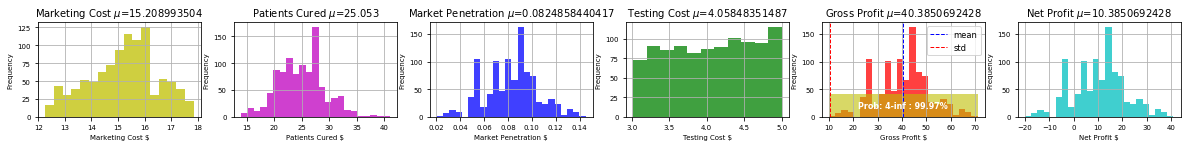

In [8]:
from theano.tensor.var import TensorVariable

nn = len(traced.varnames);
plt.figure(figsize=(24,4))

cc = 'ymbgrcmykw'*5;
varss = [v for v in traced.varnames if not v.endswith('_')]

dets = []
for m in mcmc.deterministics:
    s = str(m)
    if (type(m)) == TensorVariable and not s.endswith('_'):
        #vars.remove(s)
        dets.append(s)
        
for i, j in enumerate(varss):
    mn = np.mean(traced[j])
    nn = "{}{}{}".format(1+int(len(traced.varnames)/4),7, i+1) ;
    print (i, j, nn)
    
    if (j in dets):
        ablines=['mean', 'std']; legend=True; low=4; high=np.math.inf
    else:
        ablines=[]; legend=False; low=None; high=None
        
    plthist(traced[j], title=j+' $\mu$='+ str(mn), ylabel='Frequency', xlabel=j+' $', facecolor=cc[i], subplot=nn, ablines=ablines, legend=legend, low=low, high=high);

plt.subplots_adjust(wspace=None, hspace=.3)



In [9]:
from pymc3 import distributions
from pymc3.distributions.dist_math import *
import theano.tensor as tt

class Triangular(Continuous):
    """
    Continuous Triangular log-likelihood
    Implemented by J. A. Fonseca 22/12/16
    Parameters
    ----------
    lower : float
        Lower limit.
    c: float
        mode
    upper : float
        Upper limit.
    """

    def __init__(self, lower=0, upper=1, c=0.5,
                 *args, **kwargs):
        super(Triangular, self).__init__(*args, **kwargs)

        self.c = c
        self.lower = lower
        self.upper = upper
        self.mean = c
        self.median = self.mean

    def random(self, point=None, size=None):
        c, lower, upper = draw_values([self.c, self.lower, self.upper],
                                      point=point)
        return generate_samples(stats.triang.rvs, c=c-lower, loc=lower, scale=upper-lower,
                                size=size, dist_shape=self.shape, random_state=None)

    def logp(self, value):
        c = self.c
        lower = self.lower
        upper = self.upper
        return tt.switch(alltrue_elemwise([lower <= value, value < c]),
                         tt.log(2 * (value - lower) / ((upper - lower) * (c - lower))),
                         tt.switch(tt.eq(value, c), tt.log(2 / (upper - lower)),
                         tt.switch(alltrue_elemwise([c < value, value <= upper]),
                         tt.log(2 * (upper - value) / ((upper - lower) * (upper - c))),np.inf)))

In [ ]:
def _isin(l=0,u=4.5, n=4.6):
    if (n >=l and n <=u):
        return True;
    else:
        False
        


In [9]:
ranges=[(1,2), (3,4)]
probs=[.25,.75]

#ASSERT Validaity
if ( 1 != sum(probs) ):
    print ("Probs not equal 1")

probs.sort()
rrs = []
l=0
for j in probs:
    rrs.append((l, l+j))
    l = j
print(rrs, ranges)
#--------------------------------------------    
def isIn(r, ranges):
    p=np.random.rand()
    #print(r, p, ranges)
    for i,j in enumerate(r):
        l=j[0]
        u=j[1]
        if ( p >= l and p < u):
            return i,ranges[i]
    return None, None

vals=[];
for i in range(10):
    ii,ri = isIn(rrs, ranges)
    p= np.random.rand()
    
    l = ri[0] * (1+p);
    u = ri[1] * (1+p);

    print("Now: ",ri, l,u, p)

    pp= np.random.uniform(low=ri[0], high=ri[1])

    
    if (l >= ri[0] and u <= ri[1]):
        vals.append(ri)
    else:
        vals.append(0)

print(vals)


[(0, 0.25), (0.25, 1.0)] [(1, 2), (3, 4)]
Now:  (1, 2) 1.7031319642161313 3.4062639284322627 0.7031319642161313
Now:  (3, 4) 3.1640396786867946 4.218719571582393 0.05467989289559827
Now:  (1, 2) 1.555827070777862 3.111654141555724 0.555827070777862
Now:  (3, 4) 5.927222155778933 7.9029628743719105 0.9757407185929776
Now:  (3, 4) 3.347650252661038 4.4635336702147175 0.11588341755367948
Now:  (3, 4) 3.560745665280913 4.747660887041217 0.18691522176030417
Now:  (1, 2) 1.1499021496308512 2.2998042992617025 0.14990214963085136
Now:  (3, 4) 4.4607595313034345 5.947679375071246 0.4869198437678115
Now:  (3, 4) 4.010120808426192 5.346827744568256 0.33670693614206404
Now:  (3, 4) 4.85808316687651 6.4774442225020135 0.6193610556255035
[0, 0, 0, 0, 0, 0, 0, 0, 0, 0]


In [ ]:
from pymc3 import distributions
from pymc3.distributions.dist_math import *
import theano.tensor as tt

class Triangular1(Continuous):
    def __init__(self, lower=0, upper=1, c=0.5,
                 *args, **kwargs):
        super(Triangular1, self).__init__(*args, **kwargs)

        self.c = c
        self.lower = lower
        self.upper = upper
        self.mean = c
        self.median = self.mean
        print("__init__ Called with: ", lower, upper, c, *args, **kwargs)

    def random(self, point=None, size=None):
        c, lower, upper = draw_values([self.c, self.lower, self.upper],
                                      point=point)
        ret = generate_samples(stats.triang.rvs, c=c-lower, loc=lower, scale=upper-lower,
                                size=size, dist_shape=self.shape, random_state=None)
        
        print("random(): Called with: ", point, size, c, lower, upper, ret)
        return ret
    
    def logp(self, value):
        c = self.c
        lower = self.lower
        upper = self.upper
        ret = tt.switch(alltrue_elemwise([lower <= value, value < c]),
                         tt.log(2 * (value - lower) / ((upper - lower) * (c - lower))),
                         tt.switch(tt.eq(value, c), tt.log(2 / (upper - lower)),
                         tt.switch(alltrue_elemwise([c < value, value <= upper]),
                         tt.log(2 * (upper - value) / ((upper - lower) * (upper - c))),np.inf)))
    
        print("logp(): Called with: ", value, ret)
        return ret;


In [10]:
def D1(v):
    ret = v+1;
    print ("I am called with: ", v, ret)
    return ret

with pymc3.Model() as mcmc1:
    TT   = Triangular1("Marketing Cost", 12,18,16) #Pymc3     
    C21  = pymc3.Deterministic("Net Profit", D1(TT) )

    
    step = pymc3.Metropolis()
    traced = sample(1000, step)

nn = len(traced.varnames);
plt.figure(figsize=(20,6))

cc = 'ymbgrcmykw'*5;
for i, j in enumerate(traced.varnames):
    mn = np.mean(traced[j])
    nn = "{}{}{}".format(1+int(len(traced.varnames)/4),4, i+1) ;
    print (i, j, nn)
    
    if (j in determs):
        ablines=['mean', 'std']; legend=True; low=4; high=np.math.inf
    else:
        ablines=[]; legend=False; low=None; high=None
        
    plthist(traced[j], title=j+' $\mu$='+ str(mn), ylabel='Frequency', xlabel=j+' $', facecolor=cc[i], subplot=nn, ablines=ablines, legend=legend, low=low, high=high);

plt.subplots_adjust(wspace=None, hspace=.3)

NameError: name 'Triangular1' is not defined

In [ ]:
#TT   = Triangular1("Marketing Cost", 12,18,16) #Pymc3     
